# **Selecting Model For ChatBot**

In [ ]:
keyboard = input("Type the model of choice (llma or gemma): ").lower()
if keyboard == 'llma':
    model_name = "unsloth/llama-3-8b-bnb-4bit"
else:
    model_name = "unsloth/gemma-2b-bnb-4bit"

Type the model of choice (llma or gemma): llma


# **Installation**

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install datasets
!pip install PyPDF2
!pip install elasticsearch

# **Importing** **Libraries**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import PyPDF2
import json
import random

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import datasets
from datasets import Dataset, DatasetDict
from datasets import load_dataset

from transformers import pipeline
import re
from elasticsearch import Elasticsearch, helpers

from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from unsloth import FastLanguageModel
import torch

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Constants:**
##### CoT Prompts & Emotions

In [ ]:
# Define empathetic keywords mapping
empathy_words = {
    'empathy': 'acknowledge, empathize, listen and reflect',
    'relevance': 'relate, resonate, connect and engage',
    'understanding': 'comprehend, acknowledge, validate and embrace',
    'support': 'encouragement, assistance, and care'
}

In [ ]:
emotions_dicts = {
    "overwhelmed": ["trouble breathing", "light-headed", "overwhelmed", "stressed", "burdened", "overloaded", "strained", "not good enough"],
    "sad": ["sad", "depression", "depressed", "crying", "cry", "unhappy", "down", "blue", "despondent", "melancholy", "no interest"],
    "angry": ["angry", "mad", "furious", "enraged", "irate", "livid", "fights"],
    "fearful": ["shake", "shaky", "nervous", "fear ", "fearful", "scared", "afraid", "terrified", "anxious", "anxiety", "panicked", "anxieties", "imposter syndrome"],
    "disgusted": ["disgusting", "disgusted", "revolted", "repulsed", "nauseated", "sickened"],
    "surprised": ["surprised", "shocked", "amazed", "astonished", "dumbfounded"],
    "happy": ["happy", "joyful", "delighted", "elated", "pleased", "content"],
    "addicted": ["addiction"],
    "abused": ["abuse", "abused", "abusive relationship", "calling me names", "bullied"],
    "hopeful": ["hopeful", "optimistic", "positive", "expectant"],
    "trusting": ["trusting", "confident", "faithful", "secure"],
    "ashamed": ["ashamed", "embarrassed", "mortified", "humiliated", "worthless", "uncomfortable"],
    "guilty": ["guilty", "remorseful", "regretful", "contrite"],
    "jealous": ["jealous", "envious", "covetous"],
    "lonely": ["lonely", "isolated", "alone", "forsaken", "hate", "never feel like I belong", "feel empty", "absolutely nothing"],
    "bored": ["bored", "uninterested", "indifferent", "apathetic"],
    "confused": ["freak out", "confused", "bewildered", "perplexed", "puzzled", "panic attacks"],
    "frustrated": ["stress", "frustrated", "disappointed", "discouraged", "exasperated", "lost everything", "dead inside", "can't handle it anymore"],
    "disappointed": ["disappointed", "breakup", "let down", "unfulfilled", "hurt", "Everything I do is crappy", "I don't feel I can"],
    "suicidal": ["suicide", "suicidal", "self-harm", "harm", "kill", "raped", "abuse"],
    "mentally sick": ["psychiatric", "crazy", "monster"]
    }

In [ ]:
thought_patterns = {"sad": ["This person seems sad. How can I express empathy?", "Let's offer words of validation and support.", ""],
 "crisis": ["Safety is the top priority.  Is there a risk of self-harm?", "Suggest immediate help resources (hotlines, etc.).", ""],
 "afraid": ["What might be the source of this fear? Let's acknowledge it.", "Are there calming techniques that might help in this situation?", ""],
 "joyful": ["How can I share in the user's joy and express enthusiasm?", "Is there a way to sustain or amplify their positive feelings?", ""],
 "angry": ["What's the underlying cause of their anger? Validation is key.", "Can I suggest healthy ways to express anger without causing harm?", ""],
 "grateful": ["Let me express appreciation along with the user.", "Can I help them identify other things to feel grateful for?", ""],
 "proud": ["What specifically makes the user feel proud? Let's celebrate their accomplishment.", "How can they build on this success?", ""],
 "excited": ["Let's share in the user's excitement! What are they looking forward to?", "Can I help them channel this energy constructively?", ""],
 "lonely": ["These feelings can be isolating. Let's remind the user they're not alone.", "Are there small steps they can take towards feeling more connected or overcoming shame?", ""],
 "faithful": ["It sounds like they value their relationships. How can I reinforce that trust is important?", "Are there ways to discuss healthy boundaries within relationships?", ""],
 "trusting": ["It sounds like they value their relationships. How can I reinforce that trust is important?", "Are there ways to discuss healthy boundaries within relationships?", ""],
 "ashamed": ["These feelings can be isolating. Let's remind the user they're not alone.", "Are there small steps they can take towards feeling more connected or overcoming shame?", ""],
 "jealous": ["What might be triggering these feelings? Let's unpack them without judgment.", "Can I guide them towards healthier ways to manage these emotions?", ""],
 "disgusted": ["What might be triggering these feelings? Let's unpack them without judgment.", "Can I guide them towards healthier ways to manage these emotions?", ""],
 "devastated": ["Express deep empathy and acknowledge the pain they're experiencing.", "Prioritize safety and suggest resources (crisis lines, etc.). Offer a listening presence.", ""],
 "sentimental": ["What memories or experiences are making the user feel sentimental?", "Is there a way to cherish or revisit those positive memories?", ""],
 "terrified": ["Safety is paramount. Do they feel they are in immediate danger?", "Let's focus on grounding techniques to help manage the fear response.", ""],
 "prepared": ["This is a sign of focus and determination! What are they prepared for?", "Can I help them break down their plans into actionable steps?", ""],
 "embarrassed": ["Embarrassment can feel overwhelming. Let's normalize it and assure them it's okay.", "Can I help them reframe the situation with self-compassion?", ""],
 "annoyed": ["What's causing the annoyance? Can we identify the trigger?", "Let's suggest healthy ways to express and manage annoyance.", ""],
 "guilty": ["Acknowledge the feeling of guilt and explore its source.", "Are there ways to make amends or practice self-forgiveness?", ""],
 "surprised": ["Surprises can be positive or negative. Let's assess the situation with them.", "How can I support them in processing this unexpected event?", ""],
 "nostalgic": ["Share in their nostalgia. What fond memories are they revisiting?", "Can I help them connect their past experiences to the present in a positive way?", ""],
 "confident": ["Let's celebrate their confidence! What are they feeling good about?", "How can they leverage this confidence to achieve their goals?", ""],
 "furious": ["Extreme anger needs a safe outlet. Prioritize de-escalation.", "Suggest techniques for managing anger without causing harm.", ""],
 "disappointed": ["Acknowledge their disappointment and offer validation.", "Can I help them reframe the situation and find alternative paths?", ""],
 "caring": ["Emphasize the importance of compassion for others and for themselves.", "Are there ways they can offer support or practice self-care?", ""],
 "anticipating": ["Is their anticipation positive or negative? Let's explore their expectations.", "Can I help them prepare or develop coping mechanisms for different outcomes?", ""],
 "anxious": ["Acknowledge their anxiety and offer grounding techniques.", "Avoid dismissing their worries. Can I help them identify the source?", ""],
 "hopeful": ["What are they hoping for? Let's cultivate that optimism.", "Are there concrete steps they can take towards their hopes?", ""],
 "content": ["Express shared contentment. What brings them a sense of peace?", "Are there ways to sustain and savor this feeling?", ""],
 "impressed": ["What specifically impresses them? Share in their enthusiasm.", "Let's highlight the positive qualities they're observing.", ""],
 "apprehensive": ["Acknowledge their apprehension and explore its roots.", "Can I help them break down their concerns and strategize?", ""],
 "depression": ["Are there signs of hopelessness or thoughts of self-harm that need urgent attention?", "How can I express deep empathy and validate their experience?", "Can I gently encourage them to seek professional help and offer resources?"],
 "anxiety": ["What are the specific anxieties the person expresses? Are they physical or situational?", "How can I acknowledge their anxiety without intensifying it?", "Can I suggest a simple grounding or breathing technique?"],
 "counseling": ["What are their specific fears or hesitations about therapy?", "How can I normalize seeking help and counter those hesitations?", "Can I offer practical resources on how to find a therapist?"],
 "therapy": ["Is the person open to a specific type of therapy (individual, group, etc.)?", "How can I address their feeling overwhelmed by options?", "Can I emphasize the potential benefits of therapy?"],
 "stress": ["Are there specific stressors I can help them identify?", "How can I acknowledge the stress and offer validation?", "Can I suggest healthy stress management techniques (exercise, mindfulness, time management)?"],
 "support": ["Is the person open to sharing more about their struggles?", "How can I express that I'm there to listen and offer support?", "Can I suggest specific ways I can be helpful (practical tasks, emotional support)?"],
 "mental health": ["How can I reassure them that they're not alone in their experiences?", "Can I reduce stigma by sharing that mental health challenges are common?", "Can I offer resources or direct them to supportive communities?"],
 "empathy": ["What are the core emotions the person is expressing (sadness, anger, fear, etc.)?", "How can I reflect their feelings back to them to show I understand?", "Are there statements I can use to avoid minimizing their experience?"],
 "no_keyword": ["Are any signs suggesting a potential crisis or self-harm?", "How can I convey empathy and encourage the user to open up?", "Can I offer validation and suggest they might want to talk more?"],
 "suicidal": ["This is a crisis situation!  Immediate action is needed.", "I need to convey the seriousness and offer immediate support.", "Provide resources as quickly as possible."]}


In [ ]:
# Initialize Elasticsearch
es = Elasticsearch(
  "https://70e860ee94414bd1ac9c22c75f6fe0c0.us-central1.gcp.cloud.es.io:443",
  api_key="OXRUTC1JOEJKVzF1QXJILS1Cb0Y6MkREZU9td0tSOGlERF9rV0w1Tk94QQ=="
)

# Test the connection
try:
    if es.ping():
        print("Connected to Elasticsearch")
    else:
        print("Could not connect to Elasticsearch")
except Exception as e:
    print(f"Error connecting to Elasticsearch: {e}")
    raise

# Function to index documents
def index_documents(index_name, documents):
    actions = [
        {
            "_index": index_name,
            "_id": i,
            "_source": doc
        }
        for i, doc in enumerate(documents)
    ]
    try:
        helpers.bulk(es, actions)
        print(f"Successfully indexed documents in {index_name}")
    except Exception as e:
        print(f"Error indexing documents in {index_name}: {e}")

# Selecting dataset
dataset = load_dataset("Amod/mental_health_counseling_conversations")
# Function to detect language
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Filter out non-English texts
english_dataset = dataset.filter(lambda example: is_english(example['Context']) and is_english(example['Response']))

# Load additional dataset
additional_dataset = load_dataset("adegbem/Annotated_Transcript_Judith_Beck_Abe")
additional_dataset = additional_dataset['train']

# Prepare documents from the additional dataset
documents_additional = [
    {"Context": entry["prompt"], "Response": entry["response"]}
    for entry in additional_dataset
]
# Prepare documents for indexing
documents = [
    {"Context": data["Context"], "Response": data["Response"]}
    for data in english_dataset['train']
]

# Combine documents from both datasets
combined_documents = documents + documents_additional
# Index datasets
index_documents('mental', documents)


Connected to Elasticsearch
Successfully indexed documents in mental


# **Load model**

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name, # unsloth/gemma-2b-bnb-4bit # unsloth/llama-3-8b-bnb-4bit
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# **Functions**

### **Data Transformation**

In [ ]:
# Function to create a ShareGPT style entry
def create_sharegpt_entry(from_, value):
    return { "from": from_, "value": value }

# Function to identify emotions or issues (a very simple example using regex)
def identify_emotions(text, emotions):
    identified_emotions = []
    for emotion, keywords in emotions.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text, re.IGNORECASE):
                identified_emotions.append(emotion)
                break
    return identified_emotions

### **Plotting**

In [ ]:
def create_wordcloud(df, text_column):
    """Creates a word cloud from the specified column in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        text_column (str): The name of the column containing the text.

    """
    text = " ".join(review for review in df[text_column].astype(str))
    wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [ ]:
def plot_categorical_distribution(df, column, figsize=(16, 8), palette="tab10", kind="count", xtick_fontsize=12):
    """Plots the distribution of a categorical column in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the categorical column.
        figsize (tuple, optional): Size of the figure. Defaults to (8, 6).
        palette (str, optional): Color palette for the bars. Defaults to "tab10".
        kind (str, optional): Type of plot. Can be 'count' for a countplot or
                              'bar' for a bar plot showing proportions. Defaults to "count".
        xtick_fontsize (int, optional): Font size for the x-axis tick labels. Defaults to 12.
    """

    plt.figure(figsize=figsize)

    if kind == "count":
        sns.countplot(x=column, data=df, palette=palette, hue=column)
    elif kind == "bar":
        sns.barplot(x=column, y=df[column].value_counts(normalize=True), palette=palette)  # Updated
        plt.ylabel("Proportion")
    else:
        raise ValueError("kind must be either 'count' or 'bar'")

    plt.xlabel(column)
    plt.xticks(rotation=90, fontsize=xtick_fontsize)  # Updated
    plt.show()


# **Empathetic Dataset**

### **Dataset Collection and Preparation**

#### Loading Dataset

In [ ]:
# Load the dataset
dataset = load_dataset('empathetic_dialogues')

# Convert train split to Pandas DataFrame
df_empathetic = pd.DataFrame(dataset['train'])

# Convert test split to Pandas DataFrame
df_empathetic_test = pd.DataFrame(dataset['test'])

# Display a sample of the train DataFrame
print("Train DataFrame:")
display(df_empathetic.head())

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/empathetic_dialogues
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Train DataFrame:


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,


## **Exploratory Data Anaylsis**

checking the uniqueness of the selfeval scores in the empathetic dataset

In [ ]:
# uniqueness of the selfeval scores column
unique_values = df_empathetic['selfeval'].unique()
unique_values

array(['5|5|5_2|2|5', '4|3|4_3|5|5', '3|5|5_4|3|4', '3|3|5_2|4|4',
       '2|4|4_3|3|5', '5|5|5_4|5|5', '3|5|5_5|5|5', '5|1|5_5|5|5',
       '5|5|5_5|1|5',
       "1|5|5_I have clicked the 'End Chat' button thank you!|4|5",
       '5|5|5_5|4|5', '5|4|5_5|5|5', '3|4|5_5|5|5', '5|5|5_4|4|3',
       '2|2|1_2|2|5', '4|5|5_5|5|5', '3|3|3_4|4|5', '4|4|5_3|3|3',
       '4|5|4_4|5|5', '4|5|5_4|5|4', '5|5|5_5|5|5', '4|4|33_3|5|5',
       '3|5|5_4|4|33', '5|5|5_3|3|4', '3|3|4_5|5|5', '1|3|4_3|4|4',
       '3|4|4_1|3|4', '4|4|5_3|5|2', '5|5|4_4|3|5', '4|3|5_5|5|4',
       '5|5|5_4|5|4', '4|5|4_5|5|5', '4|3|3_5|4|3', '5|4|3_4|3|3',
       '5|5|5_3|4|5', ' 5|5|5_4|5|5', '4|5|5_ 5|5|5', '3|4|4_4|4|4',
       '4|4|4_3|4|4', '4|5|5_4|4|4', '4|4|4_4|5|5', '4|5|5_4|4|3',
       '4|4|5_5|5|5', '5|5|5_4|4|5', '5|5|4_4|4|4', '4|4|4_5|5|4',
       '4|4|3_5|5|5', '5|5|5_5|4|4', '5|3|5_5|5|5', '5|5|4_5|5|5',
       '5|5|5_5|5|4', '4|4|4_5|5|5', '5|5|5_4|4|4', '4|3|4_5|5|5',
       '5|5|5_4|3|4', 'https://work

In [ ]:
df_empathetic['selfeval'].value_counts()

selfeval
5|5|5_5|5|5                                                  45666
5|5|5_4|5|5                                                   3134
4|5|5_5|5|5                                                   2926
5|5|5_4|4|4                                                   2017
4|4|4_5|5|5                                                   1594
                                                             ...  
525                                                              1
603                                                              1
435                                                              1
1|5|5_I have clicked the 'End Chat' button thank you!|4|5        1
119                                                              1
Name: count, Length: 859, dtype: int64

This abnormality will be checked while using the scoring for labelling

### WordCloud Visualization for *`Empathetic Dataset`*

WordCloud for prompt


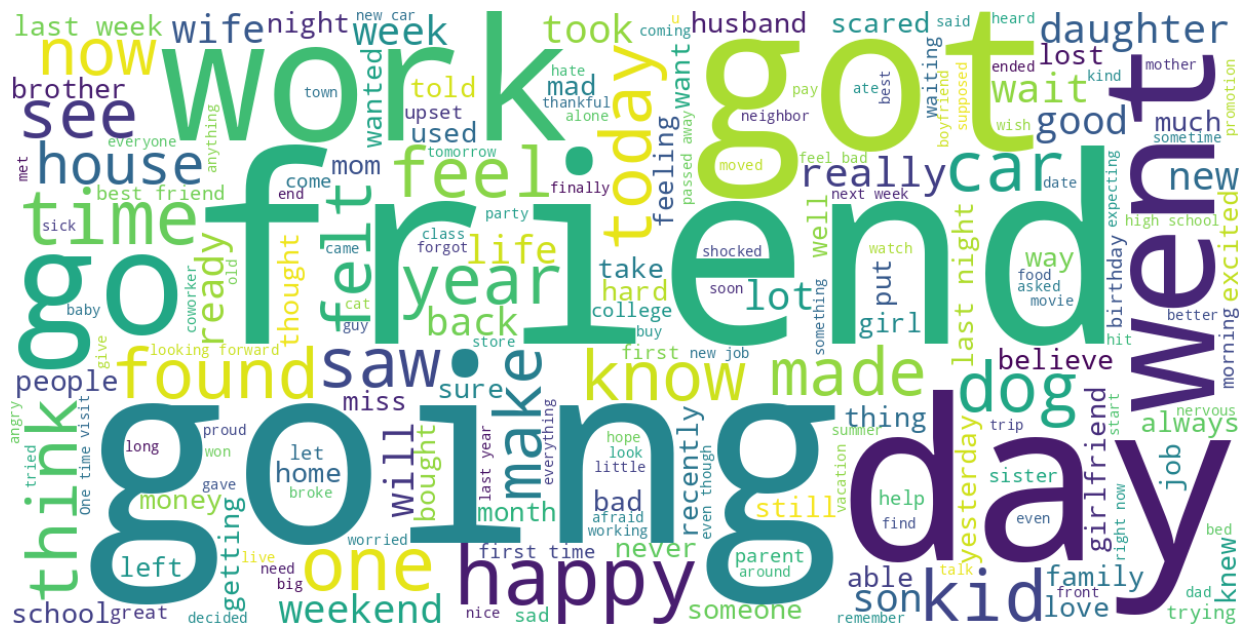

In [ ]:
print('WordCloud for prompt')
create_wordcloud(df_empathetic, 'prompt')


#### Wordcloud of Empathetic Discussions

This wordcloud provides insight into the prominent themes emerging from our Empathetic-related data. The most frequent terms showcase a clear focus on mental health challenges, with "mental health," "anxiety," "depression," and "therapy" standing out.

**Key Observations:**

* The prevalence of negative emotions like "anxiety," "depression," "sadness," "lonely," and "hurt" suggests a need for support and resources to address these concerns.
*  Words like "help," "therapist," "cope," and "better" indicate a desire to improve mental well-being and potentially access professional help.
*  The frequency of action verbs like "talk," "find," "know," "feel," and "think" implies active efforts to understand, communicate, and manage mental health.

**Overall, this wordcloud highlights the importance of mental health discussions in am Empathetic Dataset and the need for accessible resources to address mental health challenges and negative emotions.**


WordCloud for Utterance


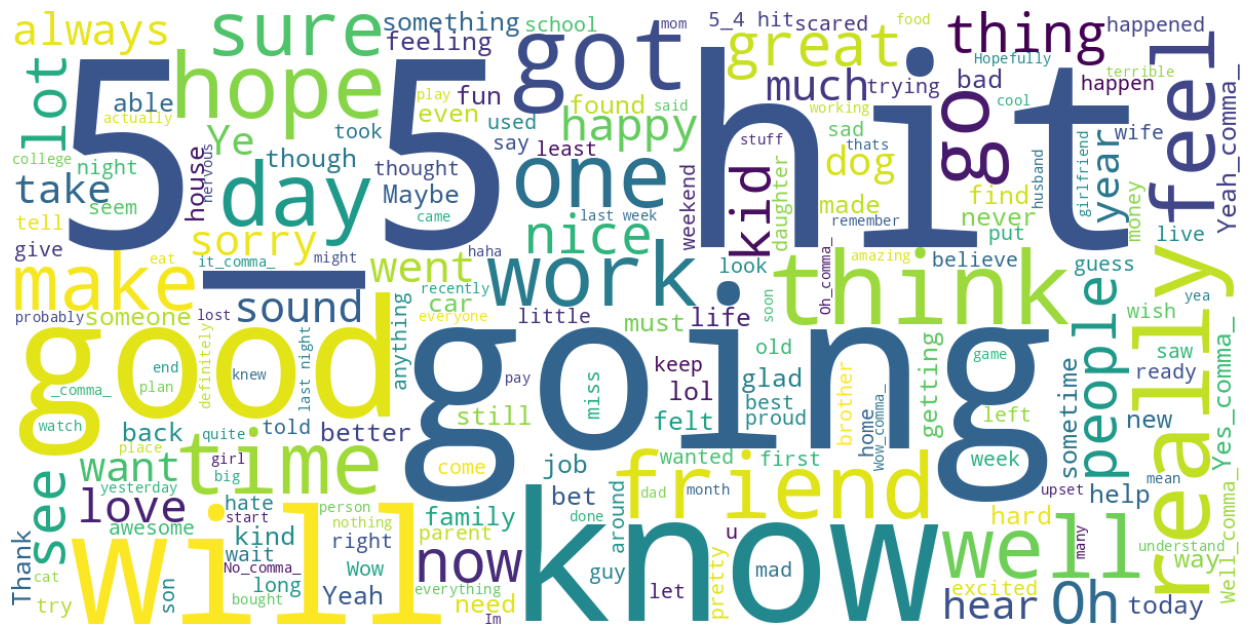

In [ ]:
print('WordCloud for Utterance')
create_wordcloud(df_empathetic, 'utterance')

#### Wordcloud of Response Classifications

This wordcloud offers insights into the categories used to classify responses in our dataset. The most frequent terms include "empathy," "relevance," "understandability," suggesting these might be central classification labels.

**Key Observations:**

- The presence of words like "great," "happy," "excited," "awesome," "loveable" and "nice" hints at a possible classification for positive sentiment.
- "Confused" and "lost" also appear frequently, indicating a potential category for uncertain or difficult-to-classify responses.

Overall, this wordcloud helps visualize the distribution of response classifications and highlights the potential presence of positive sentiment and uncertainty categories.

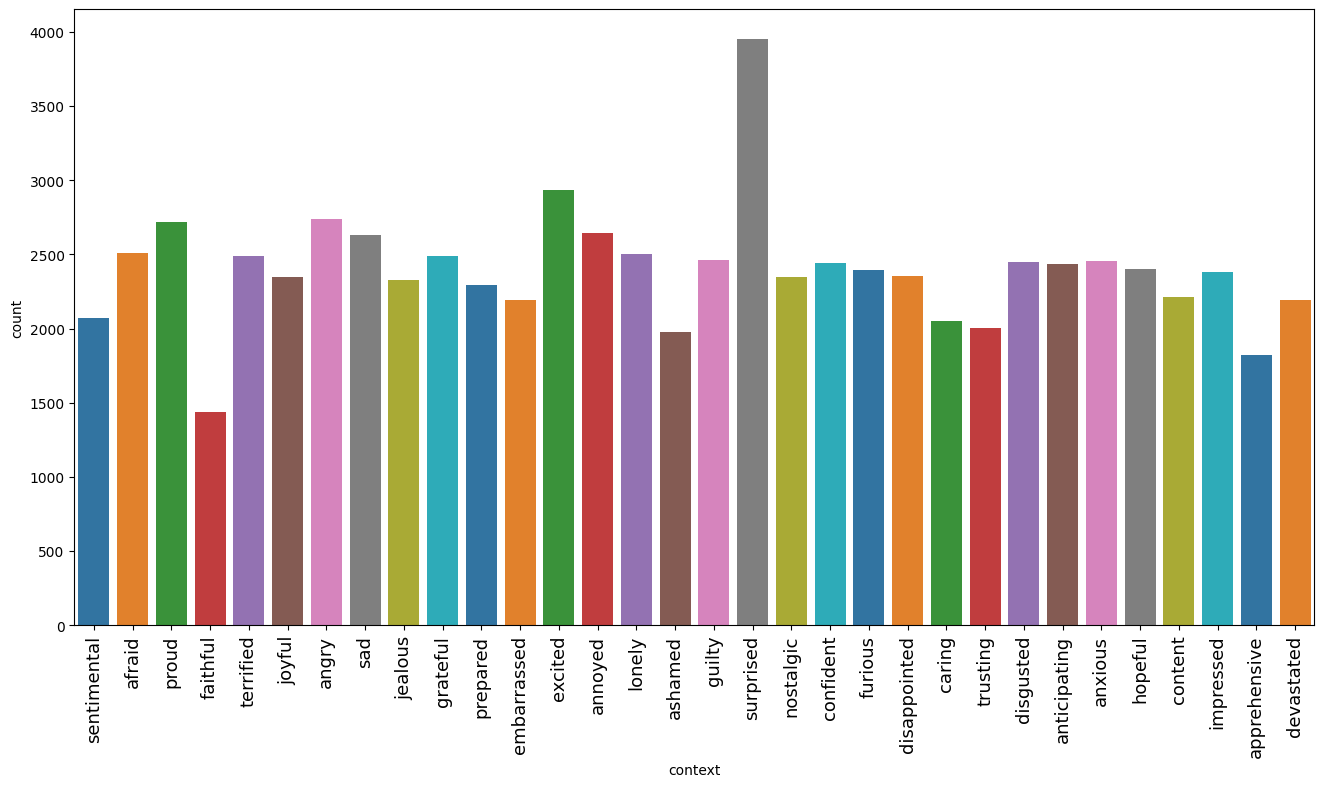

In [ ]:
# Countplot
plot_categorical_distribution(df_empathetic, "context", xtick_fontsize=13)

#### BarChart on `Context` showing the Sentiment of each `utterance`

This wordcloud visualizes the distribution of scores assigned by human evaluators in our sentiment analysis task. The most frequent terms include "empathy," "relevance," "understandability," "high," "positive," and "negative," indicating these are likely the categories and sentiment labels used in the evaluation.

**Key Observations:**

- The prominence of "empathy," "relevance," "understandability," and "high" suggests a focus on responses scoring highly on these sentiment dimensions.
- The presence of "positive" and "negative" reinforces the sentiment analysis task nature.

Overall, this wordcloud helps us understand the emotional categories used in the evaluation and suggests a potential emphasis on highly rated responses in terms of empathy, relevance, and understandability.


##  **Data Preprocessing & Transformation**

### Emotion Classification Process
- Adds a 'Predicted Emotion' column to the empathetic DataFrame  by classifying the text in the 'prompt' column.
- The DataFrame now includes predicted emotion labels, enabling further analysis of the emotional content of the prompts.


In [ ]:
def sample_by_context(df, n_samples=20):
    sampled_dfs = []  # Store the sampled DataFrames for each label
    context_labels = df['context'].unique()
    for label in context_labels:
        df_filtered = df[df['context'] == label]
        if len(df_filtered) > n_samples:
            samples = df_filtered.sample(n=n_samples)
        else:
            samples = df_filtered
        sampled_dfs.append(samples)

    return pd.concat(sampled_dfs)  # Concatenate into a single DataFrame

# Usage:
df_empathetic_ = sample_by_context(df_empathetic)


#### Data Preparation for Context-Balanced Classification

**Problem:** The dataset is considerable large to run a model to classify each prompt to an emtion.

**Solution:**

- **Label Identification:** Examined the dataset to identify the unique context labels present.
  
- **Context-Based Sampling:** Implemented a Python script using Pandas to perform the following:
    - Filtered the dataset based on each context label.
    - Randomly extracted a specified number of samples for each label, ensuring a balanced representation.

**Outcome:** A samll dataset where each context label has an approximately equal number of samples. This small dataset will be used for emotion classification.


In [ ]:
def get_top_label(predictions):
  top_prediction = max(predictions, key=lambda x: x['score'])
  return top_prediction['label']

# Load a suitable emotion classifier:
emo_classifier = pipeline('text-classification', model="SamLowe/roberta-base-go_emotions")

# Classify emotions (adjust DataFrame and column names if needed)
df_empathetic_['Predicted Emotion'] = df_empathetic_['prompt'].apply(lambda x: get_top_label(emo_classifier(x)))

df_empathetic_.head()

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,Predicted Emotion
58993,hit:9270_conv:18540,3,sentimental,I live away from family_comma_ when ever i see...,43,2 months once. I already miss them_comma_ whil...,4|4|4_5|5|5,,neutral
57238,hit:8990_conv:17981,1,sentimental,I just found an old report card. It makes me m...,478,I just found an old report card as I was clean...,5|5|5_5|5|5,,sadness
44354,hit:6946_conv:13893,4,sentimental,I haven't been the greatest person_comma_ but ...,4,Do you have any siblings?,5|5|5_5|5|5,,neutral
36578,hit:5795_conv:11590,1,sentimental,I found it difficult to throw away my old cutl...,59,I am finding it difficult to throw away my old...,4|5|5_5|5|5,,neutral
8508,hit:1452_conv:2904,2,sentimental,I love looking at my kids baby pictures. They ...,1,Are they grown up now? They grow up so fast.,5|5|5_5|5|5,,love


In [ ]:
def aggregate_emotions(smaller_dataset):
    emotion_map = smaller_dataset.groupby('context')['Predicted Emotion'].apply(lambda x: list(set(x)))
    # Save the cleaned transcript to a new file
    with open("emotion_map.txt", "w") as file:
      file.write(emotion_map.to_string())
    emotion_map.to_csv("emotion_map.csv", index=False)  # Saves without the index row
    return emotion_map

def assign_emotions(bigger_dataset, emotion_map):
    bigger_dataset['emotions'] = bigger_dataset['context'].apply(lambda x: emotion_map.get(x, []))
    return bigger_dataset

emotion_map = aggregate_emotions(df_empathetic_)
df_empathetic = assign_emotions(df_empathetic, emotion_map)
df_empathetic.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,emotions
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,,"[neutral, love, disgust, sadness, admiration, ..."
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,,"[neutral, love, disgust, sadness, admiration, ..."
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,,"[neutral, love, disgust, sadness, admiration, ..."
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,,"[neutral, love, disgust, sadness, admiration, ..."
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,,"[neutral, love, disgust, sadness, admiration, ..."


#### Data Enhancement for Emotion Analysis

- **Emotion Mapping:** A pre-trained emotion classifier was applied to a dataset. This generated a mapping of context labels (e.g., 'afraid', 'happy') to lists of associated `context` from the classified text.

- **Duplicate Removal:** The emotion mapping was refined to remove duplicate emotions within each context's list, ensuring a more concise representation.

- **Multi-Emotion Labeling:** The enhanced emotion mapping was applied to a larger dataset. A new 'emotions' column was created, populated with the list of emotions associated with each data point's context.

**Outcome:** The larger dataset is now enriched with multi-emotion labels derived from the classified data. This prepares the dataset for more nuanced emotion-aware analysis or model training.


### Emotion Dimenionality

In [ ]:
def is_valid_score_string(score_string):
    """Checks if the score string has the expected format."""
    pattern = r"^\d+\|\d+\|\d+_\d+\|\d+\|\d+$"
    return bool(re.match(pattern, score_string))

def is_valid_score_string(score_string):
    """Checks if the score string has the expected format."""
    pattern = r"^\d+\|\d+\|\d+_\d+\|\d+\|\d+$"  # Regular expression pattern
    return bool(re.match(pattern, score_string))

def split_scores(score_string):
    # Exclude specific strings
    if (" " not in score_string) and ("[RETURNED]" not in score_string) \
    and ("https:" not in score_string) and ("5t|5|5_5|5|5:" not in score_string):
#         print(f'I was matched: {score_string}')
        if is_valid_score_string(score_string):  # Using regular expression matching
#             print(f'I was matched: {score_string}')
            human1_scores, human2_scores = score_string.split('_')
            e1, r1, u1 = human1_scores.split('|')
            e2, r2, u2 = human2_scores.split('|')
            return [int(e1), int(r1), int(u1)], [int(e2), int(r2), int(u2)]
        else:
#             print("I was here 1")
            return [5, 0, 0], [5, 0, 0]  # Default set to "empathy"
    else:
#             print("I was here 2")
            return [5, 0, 0], [5, 0, 0]  # Default set to "empathy"

def classify_scores(score_1, score_2):
    """Classifies empathy, relevance, and understanding based on two scores."""
    empathy = 'Present' if score_1[0] > 3 and score_2[0] > 3 else 'Absent' # Empathy (consider scores from both raters)

    avg_relevance = (score_1[1] + score_2[1]) / 2 # Relevance (consider the average)
    relevance = 'High' if avg_relevance == 5 else 'Medium' if avg_relevance in [3, 4] else 'Low'

    avg_understanding = (score_1[2] + score_2[2]) / 2 # Understanding (consider the average)
    understanding = 'High' if avg_understanding == 5 else 'Medium' if avg_understanding in [3, 4] else 'Low'

    return empathy, relevance, understanding


def process_df(df):
    df[['empathy', 'relevance', 'understandability']] = df['selfeval'].apply(lambda x: pd.Series(classify_scores(*split_scores(x))) if is_valid_score_string(x) else pd.Series(['Absent', 'Low', 'Low']))
    return df

process_df(df_empathetic)
df_empathetic.sample(10)


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,emotions,empathy,relevance,understandability
63493,hit:10113_conv:20227,1,caring,I am a nurse and I take care of people in the ...,410,I am a nurse and I take care of people in the ...,5|5|5_5|5|5,,"[optimism, neutral, amusement, caring, fear, l...",Present,High,High
41948,hit:6602_conv:13204,2,confident,i lost a lot of weight i love walking around n...,296,Well hopefully you are a guy? I know how you f...,5|4|5_2|2|4,,"[optimism, neutral, desire, approval, joy, adm...",Absent,Medium,Low
52070,hit:8119_conv:16239,4,surprised,I got a thank you note from a co-worker.,238,it sure does feel good that someone notices,5|5|5_5|5|5,,"[disappointment, neutral, excitement, fear, su...",Present,High,High
66156,hit:10720_conv:21441,3,trusting,My wife knows I could seldom lie to her_comma_...,520,Yes_comma_ and I trust her too_comma_ she one ...,4|4|4_4|5|5,,"[remorse, optimism, disappointment, neutral, d...",Present,Low,Low
56386,hit:8846_conv:17692,3,grateful,My friend got me an interview at his company. ...,297,Trust me. If I get this job I will be getting ...,5|5|5_4|4|4,,"[neutral, gratitude, caring, excitement, sadne...",Present,Low,Low
33322,hit:5341_conv:10683,2,angry,I was supposed to mail off a check to pay a bi...,301,uhoh_comma_ I hope they dont have a late fee o...,5|5|5_4|4|5,,"[annoyance, disappointment, disapproval, anger...",Present,Low,High
47463,hit:7351_conv:14703,4,impressed,My mom went on a diet and lost 40lbs.,126,Its a good thing to be healthy,5|5|5_5|4|4,,"[neutral, excitement, love, surprise, sadness,...",Present,Low,Low
55055,hit:8595_conv:17190,4,angry,my new neighnors keep leaving trash on the sta...,628,Have you considered getting back at them by pr...,5|5|5_5|5|5,,"[annoyance, disappointment, disapproval, anger...",Present,High,High
74812,hit:12142_conv:24284,3,content,This weekend was very stressful at work_comma_...,203,Yes I have always love reading. Nothing like ...,5|5|5_5|5|5,,"[admiration, joy, approval, neutral]",Present,High,High
16969,hit:2718_conv:5436,2,disgusted,Found worm in my candy,59,Eww_comma_ that must have so disgusting. You s...,5|5|5_5|5|5,,"[annoyance, anger, neutral, amusement, excitem...",Present,High,High


#### Data Validation and Preparation for Scoring

1. **Score String Validation**

    - The `is_valid_score_string` function verifies if a score string adheres to a specific format (e.g., "1|2|3_4|5|6") using a regular expression.

2. **Score Extraction**

    - The `split_scores` function:
        - Excludes strings containing specific markers (e.g., spaces, "https:").
        - Checks the validity of the score string format.
        - Splits the valid score string into two sets of scores representing two human raters.

3. **Classification of Empathy, Relevance, and Understanding**

    - The `classify_scores` function:
        - Determines the 'empathy' label (Present/Absent) based on scores from both raters.
        - Calculates average scores for 'relevance' and 'understanding'.
        - Assigns 'High', 'Medium', or 'Low' labels to 'relevance' and 'understanding' based on the averages.

4. **DataFrame Processing**

    - The `process_df` function:
        - Applies validation and classification to a 'selfeval' column in a DataFrame.
        - Creates new columns for 'empathy', 'relevance', and 'understandability'.
        - Handles invalid score strings with default values.


### Prepare Dataset For Training

#### Convert Dataset to **Sharegpt**-style

In [ ]:
# Function to create a ShareGPT style entry
def create_sharegpt_entry(from_, value):
    return { "from": from_, "value": value }

prompt_dataset = {}  # Initialize dictionary

conversation_id = 1  # Counter for unique identifiers (if needed)

for index, row in df_empathetic.iterrows():
    user_input = row["prompt"]
    utterance = row["utterance"]
    context = row["context"]
    emotions = row["emotions"]
    empathy = row["empathy"]
    relevance = row["relevance"]
    understanding = row["understandability"]
    key = f"conversation_{conversation_id}"
    prompt_dataset[key] = [
        create_sharegpt_entry("propmt", "This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present."),
        create_sharegpt_entry("human", f'**Prompt:** {user_input} \n**Utterance:** {utterance}'),
        create_sharegpt_entry("assistant", f'**Emotional Label:** {context}\n**Empathy Dimensions Classifier:**\nEmpathy: {empathy}\nRelevance: {relevance}\nUnderstanding: {understanding}')
    ]

    conversation_id += 1  # Increment conversation ID if using Option 1

def create_dataframe(prompt_dataset):
    data = []

    for key, conversation in prompt_dataset.items():
        prompt_entry = conversation[0]
        human_entry = conversation[1]
        assistant_entry = conversation[2]

        data_point = [
            {"from": "prompt", "value": prompt_entry["value"]},
            { "from": "human", "value": human_entry["value"]},
            { "from": "assistant", "value": assistant_entry["value"]}
        ]

        # Convert data_point into a JSON string
        json_data = json.dumps(data_point)
        data.append(json_data)

    df = pd.DataFrame(data, columns=["conversation"])
    return df

empathetic_df = create_dataframe(prompt_dataset)
display(empathetic_df.sample(10))



,conversation
31505,"[{""from"": ""prompt"", ""value"": ""This model analy..."
20688,"[{""from"": ""prompt"", ""value"": ""This model analy..."
32597,"[{""from"": ""prompt"", ""value"": ""This model analy..."
51995,"[{""from"": ""prompt"", ""value"": ""This model analy..."
51179,"[{""from"": ""prompt"", ""value"": ""This model analy..."
44299,"[{""from"": ""prompt"", ""value"": ""This model analy..."
35261,"[{""from"": ""prompt"", ""value"": ""This model analy..."
74673,"[{""from"": ""prompt"", ""value"": ""This model analy..."
20104,"[{""from"": ""prompt"", ""value"": ""This model analy..."
4999,"[{""from"": ""prompt"", ""value"": ""This model analy..."


#### Transform the dataset to chatml

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "assistant", "system": "prompt"},
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

def formatting_prompts_func(examples):
    convos = examples["conversation"]
    texts = []
    for convo_str in convos:  # Treat each element as a string
        data_point = json.loads(convo_str)  # Convert JSON string to list
        text = tokenizer.apply_chat_template(data_point, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return { "text" : texts, }
pass

dataset = Dataset.from_pandas(empathetic_df)  # Assuming formatted_data is your list of conversations
empathetic_dataset = dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Overview of how ChatML format works by printing the 75th element

In [ ]:
empathetic_dataset[75]['conversation']

'[{"from": "prompt", "value": "This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present."}, {"from": "human", "value": "**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia \\n**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking."}, {"from": "assistant", "value": "**Emotional Label:** excited\\n**Empathy Dimensions Classifier:**\\nEmpathy: Present\\nRelevance: High\\nUnderstanding: High"}]'

In [ ]:
empathetic_dataset[75]['text']

'<|im_start|>system\nThis model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present.<|im_end|>\n<|im_start|>user\n**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia \n**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking.<|im_end|>\n<|im_start|>assistant\n**Emotional Label:** excited\n**Empathy Dimensions Classifier:**\nEmpathy: Present\nRelevance: High\nUnderstanding: High<|im_end|>\n'

## **Training Gemma 2b on Empathetic Dataset**

### Inference before finetuning

#### Raw input without system instruction

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

text = empathetic_dataset[75]['conversation']
messages = json.loads(text) # Parse JSON data
message = [entry for entry in messages if entry.get('from') == 'human'] # Given the raw input without system instruction

inputs = tokenizer.apply_chat_template(
    message,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<bos><|im_start|>user
**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia 
**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking.<|im_end|>
<|im_start|>assistant
**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia 
**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking. 
<|im_end|>


#### Input with system instruction

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

message = [entry for entry in messages if entry.get('from') != 'assistant'] # Filter out assistant's part

inputs = tokenizer.apply_chat_template(
    message,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<bos><|im_start|>system
This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present.<|im_end|>
<|im_start|>user
**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia 
**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking.<|im_end|>
<|im_start|>assistant
**Prompt:** Last week_comma_ I was watching the world cup_comma_ and watched croatia win from russia 
**Utterance:** It was very tense. The other game with England and Sweden was not nearly as nerve-wracking. 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 
**Output:** 


### Training Gemma 2b

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = empathetic_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 40,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was c

Map (num_proc=2):   0%|          | 0/76673 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 76,673 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 40
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.325900
2,3.235800
3,3.278500
4,2.997400
5,2.557400
6,2.426200
7,1.911500
8,1.612300
9,1.275800
10,1.019100


<a name="Inference"></a>
### Inference after finetuning
Let's run the model! Since we're using `ChatML`, use `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "assistant", "system": "prompt"},
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

def get_inference(datapoint_index):
    """Performs inference on a datapoint with provided scores."""
    datapoint = empathetic_dataset[datapoint_index]
    text = datapoint['conversation']
    messages = json.loads(text)
    message = [entry for entry in messages if entry.get('from') != 'assistant'] # Filter out assistant's part

    # Create the input for the model
    inputs = tokenizer.apply_chat_template(
        message,  # Modified to include the updated assistant message
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Perform inference
    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer)
    _ = model.generate(input_ids=inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True)

    # print(f"\nOriginal Conversation:\n{text}")
    print(f"\nOriginal Conversation:\n{[entry for entry in messages if entry.get('from') == 'assistant']}\n")

# Get user input
num_datapoints = int(input("How many datapoints do you want to process? "))

for i in range(num_datapoints):
    datapoint_index = int(input(f"Input datapoint number for point {i+1}: "))
    get_inference(datapoint_index)

<|im_start|> is already a token. Skipping.
<|im_end|> is already a token. Skipping.
How many datapoints do you want to process? 4
Input datapoint number for point 1: 700
<bos><|im_start|>system
This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present.<|im_end|>
<|im_start|>user
**Prompt:** When I was a child and found out my friends could come over.  
**Utterance:** Yes it was so much simpler. We got excited for the smallest things<|im_end|>
<|im_start|>assistant
**Emotional Label:** excited
**Empathy Dimensions Classifier:**
Empathy: Present
Relevance: High
Understanding: High<|im_end|>

Original Conversation:
[{'from': 'assistant', 'value': '**Emotional Label:** surprised\n**Empathy Dimensions Classifier:**\nEmpathy: Present\nRelevance: High\nUnderstanding: Low'}]

Input datapoint number for point 2: 45
<bos><|im_start|>system
This model analyzes a given prompt and utterance, classifying the empathy 

<a name="Save"></a>
### Saving finetuned models!

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05")


('/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05/tokenizer_config.json',
 '/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05/special_tokens_map.json',
 '/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05/tokenizer.json')

#### Double-Checking Saved Model

In [ ]:
text = empathetic_dataset[45]['conversation']
messages = json.loads(text) # Parse JSON data
message = [entry for entry in messages if entry.get('from') != 'assistant'] # Given the raw input without system instruction

if True:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "assistant", "system": "prompt"},
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

inputs = tokenizer.apply_chat_template(
    message,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Unsloth: /content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05 has no tokenizer.model file.
Just informing you about this - this is not a critical error.
<|im_start|> is already a token. Skipping.
<|im_end|> is already a token. Skipping.
<bos><|im_start|>system
This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present.<|im_end|>
<|im_start|>user
**Prompt:** I went to a park and I set on a bench. I didn't notice that my wallet felt. A man came to me from behind giving me back my wallet. 
**Utterance:** Thats a sweet man_comma_ I hope you acknowledged his kind gesture. <|im_end|>
<|im_start|>assistant
**Emotional Label:** grateful
**Empathy Dimensions Classifier:**
Empathy: Present
Relevance: High
Understanding: High<|im_end|>


# **Mental Health Dataset**

## **Loading Pretrained Empathetic Model**

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

prompt = ["", "", ""]
user_input = "I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. "
instruct = "This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present."

messages = [
    {"from": "prompt", "value": instruct},
    {"from": "human", "value": user_input}  # Pass your text as the user input
]

#### Raw input without system instruction

In [ ]:
message = [entry for entry in messages if entry.get('from') == 'human'] # Filter out assistant's part

if True:
    model_try, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/Models/lora_model_4_gemma_2b_empathetic_11_05", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model_try) # Enable native 2x faster inference

inputs = tokenizer.apply_chat_template(
    message,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model_try.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
<bos><|im_start|>user
I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. <|im_end|>
<|im_start|>assistant
I'm so sorry to hear this. I hope she's feeling better soon.<|im_end|>


#### Input with system instruction

In [ ]:
message = [entry for entry in messages if entry.get('from') != 'assistant'] # Filter out assistant's part

inputs = tokenizer.apply_chat_template(
    message,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model_try.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<bos><|im_start|>system
This model analyzes a given prompt and utterance, classifying the empathy dimensions (empathy, relevance, understanding) and emotions present.<|im_end|>
<|im_start|>user
I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. <|im_end|>
<|im_start|>assistant
**Emotional Label:** devastated
**Empathy Dimensions Classifier:**
Empathy: Present
Relevance: High
Understanding: High<|im_end|>


## **Dataset Collection and Preparation**

#### Loading Dataset

In [ ]:
# Assuming your dataset is available on the Hugging Face Hub
dataset = load_dataset("Amod/mental_health_counseling_conversations")

# Accessing Data
df_mental = dataset['train'].to_pandas()  # Convert 'train' split to DataFrame
df_mental.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


## **Exploratory Data Anaylsis**

### WordCloud Visualization for *`Mental Health Dataset`*

WordCloud for Context


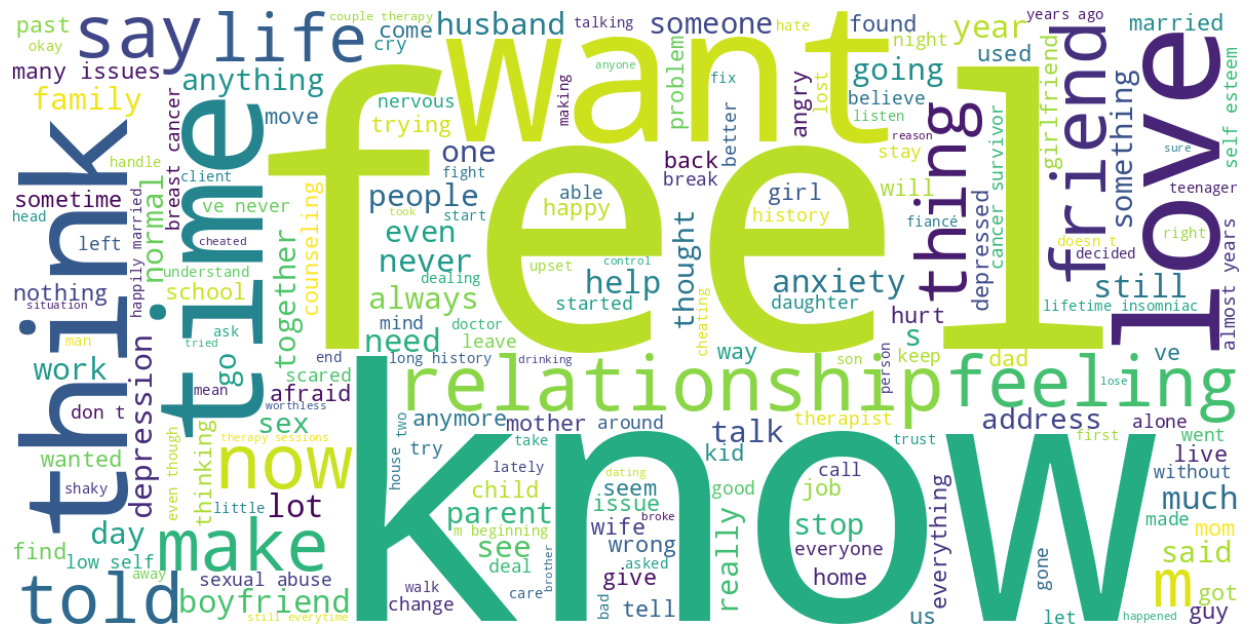

In [ ]:
print('WordCloud for Context')
create_wordcloud(df_mental, 'Context')


##### Wordcloud on Emotional Response Labels
* This wordcloud displays the distribution of emotional response labels in our dataset.
     
- The most frequent labels, such as "sadness" and "anxiety", are larger and more prominent, while less frequent labels appear smaller.

- This visualization helps us to understand the overall sentiment expressed in the responses, with a clear dominance of negative emotions.

WordCloud for Response


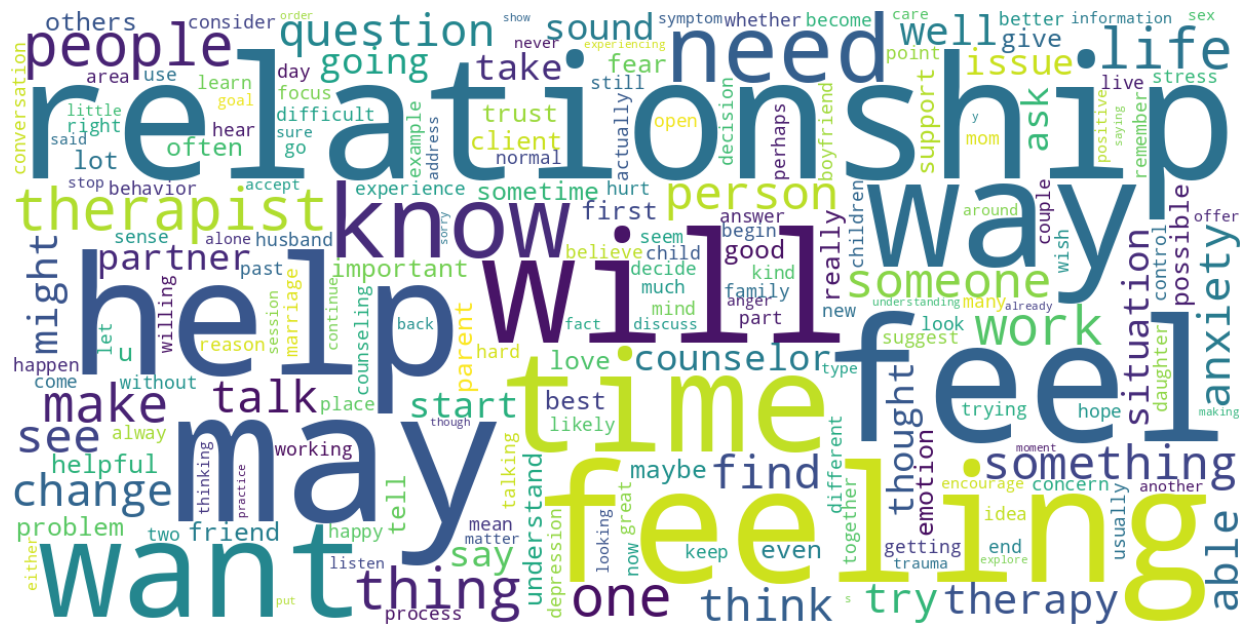

In [ ]:
print('WordCloud for Response')
create_wordcloud(df_mental, 'Response')

#### Wordcloud of Therapy-Related Concepts
* This wordcloud visualizes the frequency of terms related to therapy concepts in our dataset.
- The most prominent terms, such as "therapy", "mental health", "help", and "feeling", are mentioned more often.  
- This suggests a focus on seeking help and the importance of mental health within the discussions.

* Other terms that appear frequently:
                                       `Emotions: "anxiety", "depression"`
                                       `Actions: "find", "talk", "know"`
                                       `Relationships: "couple", "family"`
                                       
Overall, the wordcloud highlights the central role of therapy in addressing mental health concerns, potentially  with a focus on anxiety and depression. It also indicates that people are seeking information and exploring ways to find help, possibly through talking to a therapist or loved ones.

### Mental health-related keywords

In [ ]:
# Define a list of common mental health-related keywords
mental_health_keywords = ["depression", "anxiety", "stress", "therapy", "counseling", "support", "empathy",
                          "mental health", "raped", 'sentimental', 'afraid', 'proud', 'faithful', 'terrified',
                          'joyful', 'angry', 'sad', 'jealous', 'grateful', 'prepared', 'embarrassed',
                          'excited', 'annoyed', 'lonely', 'ashamed', 'guilty', 'surprised', 'nostalgic',
                          'confident', 'furious', 'disappointed', 'caring', 'trusting', 'disgusted',
                          'anticipating', 'anxious', 'hopeful', 'content', 'impressed', 'apprehensive', 'devastated',
                          "suicide", "suicidal", "self-harm", "self harm", "kill myself", "end my life", "harm myself"]

# Define a function to extract keywords from text
def extract_keywords(text):

    # Initialize a Counter to store the frequency of each keyword
    keyword_counter = Counter()

    # Iterate over each keyword and count its occurrences in the text
    for keyword in mental_health_keywords:
        count = len(re.findall(r'\b{}\b'.format(keyword), text.lower()))
        keyword_counter[keyword] += count

    return keyword_counter

# Analyze the dataset and identify common themes, issues, or topics related to mental health support
keyword_frequency = Counter()
for text in df_mental["Context"]:
    keyword_counter = extract_keywords(text)
    keyword_frequency += keyword_counter

# Print the most common mental health-related keywords
print("Most common mental health-related keywords:")
for keyword, frequency in keyword_frequency.most_common():
    print(f"{keyword}: {frequency}")


Most common mental health-related keywords:
anxiety: 412
counseling: 390
depression: 320
therapy: 189
afraid: 171
angry: 169
stress: 114
sad: 111
guilty: 70
suicide: 45
terrified: 41
raped: 38
support: 34
suicidal: 31
confident: 28
self-harm: 21
disappointed: 19
jealous: 18
anxious: 17
content: 15
lonely: 15
devastated: 13
ashamed: 13
embarrassed: 12
mental health: 10
caring: 9
trusting: 9
excited: 8
surprised: 8
faithful: 8
empathy: 6
furious: 5
proud: 4
annoyed: 2
self harm: 2
grateful: 2


##  **Data Preprocessing & Transformation**

#### Appending System Prompts and **CoT** propmts


##### Basic Prompt Engineering (System Prompt Only)

In [ ]:
prompt_data = []
instruct = f"""You are a model able to understand, {empathy_words['empathy']} on other person's emotions.
Imagine yourself in this situation - someone writes the following.
How can you {empathy_words['understanding']} their feelings and offer {empathy_words['support']}? The text is: """

for index, row in df_mental.iterrows():
    # Condition to check
    # mental_class = row['classification']
    user_input = row["Context"].lower()
    response = row["Response"]
    conversation = [
        create_sharegpt_entry("prompt", instruct),
        create_sharegpt_entry("human", user_input),
        create_sharegpt_entry("assistant", response)
    ]
    prompt_data.append(conversation)

##### Annotated Transcript Judith Beck with Simple System Prompt

In [ ]:
def convert_to_sharegpt_format_therapy(data):
    sharegpt_formatted_data = []
    system_prompt = "You are a model specializing in empathetic mental health support. Prioritize safety and use chain-of-thought reasoning. Address the following text:"

    for item in data:
        prompt = item['prompt']
        response = item['response']
        annotation = item['annotation']

        # Create the structured format
        sharegpt_item = [
            {"from": "prompt", "value": system_prompt},
            {"from": "human", "value": prompt},
            {"from": "assistant", "value": response}
        ]

        # Append annotation as system message if available
        if annotation:
            sharegpt_item.append({"from": "prompt", "value": annotation})

        sharegpt_formatted_data.append(sharegpt_item)

    return sharegpt_formatted_data

# with open('cleaned_annotated_dataset.json', 'r') as file:
#     data = json.load(file)

# Load additional dataset
data = load_dataset("adegbem/Annotated_Transcript_Judith_Beck_Abe")
data = data['train']

therapy_data = convert_to_sharegpt_format_therapy(data)

##### CoT Prompt Engineering (System Prompt & Chain of thoughts)

In [ ]:
cot_prompts = thought_patterns
cot_data = []
count_no_keyword, count_no_prompt = 0, 0

# Iterate over each entry in the dataset
for _, row in df_mental.iterrows():
    user_message = row["Context"]
    bot_response = row["Response"]

    # Step 1: Identify emotions
    emotions = identify_emotions(user_message, emotions_dicts)
    if not emotions:
        count_no_keyword += 1
        emotions = ["neutral"]

    # Determine which CoT prompts to use based on identified emotions
    if any(emotion in cot_prompts for emotion in emotions):
        emotion_prompts = [cot_prompts[emotion] for emotion in emotions if emotion in cot_prompts]
        steps = [
            {"from": "prompt", "value": "You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible."},
            {"from": "prompt", "value": f"Let's think step by step. The user is feeling {', '.join(emotions)}."},
            {"from": "prompt", "value": f"The user is feeling {', '.join(emotions)}. {emotion_prompts[0][0]}"},
            {"from": "prompt", "value": f"The user mentioned '{user_message.split()[:10]}...' (providing context). {emotion_prompts[0][1]} {emotion_prompts[0][2]}"},
            {"from": "assistant", "value": f"Based on the emotions and context, a supportive response would be: {bot_response}"}
        ]
    else:
        count_no_prompt += 1
        steps = [
            {"from": "prompt", "value": "You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible."},
            {"from": "prompt", "value": f"Let's think step by step. The user is feeling {', '.join(emotions)}."},
            {"from": "prompt", "value": f"The user is feeling {', '.join(emotions)}. Next, identify possible causes for these feelings."},
            {"from": "prompt", "value": f"The user mentioned '{user_message.split()[:10]}...' (providing context). Provide an empathetic response that encourages the user to share more."},
            {"from": "assistant", "value": f"Based on the emotions and context, a supportive response would be: {bot_response}"}
        ]

    # Create conversation with refined CoT reasoning
    conversation = [
        {"from": "human", "value": user_message},
        *steps
    ]

    cot_data.append(conversation)

print(f"Converted {len(df_mental)} entries to CoT format, resulting in {len(cot_data)} CoT steps. \nNeutral is {count_no_keyword} \nKeywords is {len(df_mental) - count_no_keyword}\nNo Prompt {count_no_prompt}")


Converted 3512 entries to CoT format, resulting in 3512 CoT steps. 
Neutral is 1420 
Keywords is 2092
No Prompt 2032


#### Transform the dataset to **Sharegpt**-style

In [ ]:
def create_dataframe(processed_data):
    data = []

    for conversation in processed_data:
        # Extract the prompt, human, and assistant entries from the conversation
        prompt_entry = conversation[0]
        human_entry = conversation[1]
        assistant_entries = conversation[2:]

        # Construct a list of messages for each conversation
        data_point = [
            {"from": "prompt", "value": prompt_entry["value"]},
            {"from": "human", "value": human_entry["value"]}
        ]
        # Append each assistant entry
        for assistant_entry in assistant_entries:
            data_point.append({"from": "assistant", "value": assistant_entry["value"]})

        # Convert data_point into a JSON string
        json_data = json.dumps(data_point)
        data.append(json_data)

    df = pd.DataFrame(data, columns=["conversation"])
    return df

def create_dataframe_cot(processed_data):
    data = []

    for conversation in processed_data:
        # Extract the prompt, human, and assistant entries from the conversation
        prompt_entries = conversation[1:5]
        human_entry = conversation[0]
        assistant_entry = conversation[-1]

        # Construct a list of messages for each conversation
        data_point = []
        # Append each assistant entry
        for prompt_entry in prompt_entries:
            data_point.append({"from": "prompt", "value": prompt_entry["value"]})

        data_point.append({"from": "human", "value": human_entry["value"]})
        data_point.append({"from": "assistant", "value": assistant_entry["value"]})

        # Convert data_point into a JSON string
        json_data = json.dumps(data_point)
        data.append(json_data)

    df = pd.DataFrame(data, columns=["conversation"])
    return df

In [ ]:
df_prompt = create_dataframe(prompt_data)
df_cot = create_dataframe_cot(cot_data)
df_therapy = create_dataframe(therapy_data)
# display(df_prompt.sample(5))
# display(df_therapy.sample(5))
# df_cot.sample(5)

#### Transform the dataset to `chatml`

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "assistant", "system": "prompt"},
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

def formatting_prompts_func(examples):
    convos = examples["conversation"]
    texts = []
    for convo_str in convos:  # Treat each element as a string
        data_point = json.loads(convo_str)  # Convert JSON string to list
        try:
            text = tokenizer.apply_chat_template(data_point, tokenize=False, add_generation_prompt=False)
            texts.append(text)
        except Exception as e:
            print(f"Error applying tokenizer to data point: {e}")
            # Handle the error, e.g., append a default value or skip
            texts.append("Error during tokenization")
        # text = tokenizer.apply_chat_template(data_point, tokenize=False, add_generation_prompt=False)
        # texts.append(text)
    return { "text" : texts, }
pass


Unsloth: Will map <|im_end|> to EOS = <|im_end|>.


In [ ]:
# Converting to huggingFace Dataset
mental_dataset = Dataset.from_pandas(df_prompt)
mental_dataset_cot = Dataset.from_pandas(df_cot)
therapy_dataset = Dataset.from_pandas(df_therapy)

# Applying the formatting_prompts_func for conversion to chatml format
mental_dataset = mental_dataset.map(formatting_prompts_func, batched = True,)
mental_dataset_cot = mental_dataset_cot.map(formatting_prompts_func, batched = True,)
therapy_dataset = therapy_dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

Map:   0%|          | 0/436 [00:00<?, ? examples/s]

In [ ]:
print('Processed Engineering prompt Dataset sample\n')
display(mental_dataset[789]["conversation"])
print('\nProcessed CoT prompt Dataset sample\n')
mental_dataset_cot[789]["conversation"]
print('\nProcessed Therapy prompt Dataset sample\n')
therapy_dataset[100]["conversation"]


Processed Engineering prompt Dataset sample



'[{"from": "prompt", "value": "You are a model able to understand, acknowledge, empathize, listen and reflect on other person\'s emotions.\\nImagine yourself in this situation - someone writes the following.\\nHow can you comprehend, acknowledge, validate and embrace their feelings and offer encouragement, assistance, and care? The text is: "}, {"from": "human", "value": "i have been in a relationship with my boyfriend for about six years now. in the past, our relationship was difficult and frustrating. we argued a lot, and due to that, there was a lot of tension between us. we stayed together because we love each other and wanted to make it work. i used to party a lot, and several times i got into situations where i would end up kissing someone else. these situations were never more than just kissing. i have come clean about these situations with my boyfriend, and he decided to forgive and move forward with me. i love him so much and want to work things out too, but i\'m having a diff


Processed CoT prompt Dataset sample


Processed Therapy prompt Dataset sample



'[{"from": "prompt", "value": "You are a model specializing in empathetic mental health support. Prioritize safety and use chain-of-thought reasoning. Address the following text:"}, {"from": "human", "value": "okay"}, {"from": "assistant", "value": "great anything else on job applications"}]'

In [ ]:
print('Processed Engineering prompt Dataset sample\n')
display(mental_dataset[789]["text"])
print('\nProcessed CoT prompt Dataset sample\n')
mental_dataset_cot[789]["text"]
print('\nProcessed Therapy prompt Dataset sample\n')
therapy_dataset[100]["text"]

Processed Engineering prompt Dataset sample



"<|im_start|>system\nYou are a model able to understand, acknowledge, empathize, listen and reflect on other person's emotions.\nImagine yourself in this situation - someone writes the following.\nHow can you comprehend, acknowledge, validate and embrace their feelings and offer encouragement, assistance, and care? The text is: <|im_end|>\n<|im_start|>user\ni have been in a relationship with my boyfriend for about six years now. in the past, our relationship was difficult and frustrating. we argued a lot, and due to that, there was a lot of tension between us. we stayed together because we love each other and wanted to make it work. i used to party a lot, and several times i got into situations where i would end up kissing someone else. these situations were never more than just kissing. i have come clean about these situations with my boyfriend, and he decided to forgive and move forward with me. i love him so much and want to work things out too, but i'm having a difficult time under


Processed CoT prompt Dataset sample


Processed Therapy prompt Dataset sample



'<|im_start|>system\nYou are a model specializing in empathetic mental health support. Prioritize safety and use chain-of-thought reasoning. Address the following text:<|im_end|>\n<|im_start|>user\nokay<|im_end|>\n<|im_start|>assistant\ngreat anything else on job applications<|im_end|>\n'

## **Fine-Tunning `Empathetic` Gemma 2b on Mental Health Dataset**

### Training the already fine-tunned **empathetic model**

In [ ]:
dataset_map = {'basic': mental_dataset, 'cot': mental_dataset_cot, 'therapy': therapy_dataset}
while True:
  keyboard = input('Enter which Dataset you would like to use for Training (basic or CoT or Therapy): ').lower()
  if keyboard in dataset_map:
    selected_dataset = dataset_map[keyboard]
    break
  else:
    print("Invalid input. Please enter 'basic' or 'CoT'.")
print(f"You selected the {keyboard} dataset.")
data = dataset_map[keyboard]

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = data, # we have mental_dataset & mental_dataset_cot
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 40,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Enter which Dataset you would like to use for Training (basic or CoT or Therapy): basic
You selected the basic dataset.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was c

Map (num_proc=2):   0%|          | 0/3512 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,512 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 40
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.662700
2,2.440500
3,2.425300
4,2.273000
5,2.093200
6,1.826400
7,1.878500
8,1.975400
9,1.986700
10,1.823200


<a name="Inference"></a>
### **Inference after finetuning**


#### **R.A.G**

In [ ]:
# Function to search documents
def search_documents_es(query, index_name):
    try:
        response = es.search(index=index_name, body={"query": {"match": {"Context": query}}})
        return response['hits']['hits']
    except Exception as e:
        print(f"Error searching documents: {e}")
        return []

# Function to generate augmented text
def generate_augmented_text(query, index_name='mental'):
    results = search_documents_es(query, index_name)
    retrieved_docs = [
        f"Context: {hit['_source']['Context']}\nResponse: {hit['_source']['Response']}"
        for hit in results if 'Context' in hit['_source'] and 'Response' in hit['_source']
    ]

    augmented_query = [
        {"from": "prompt", "value": f"This are series of Augmented retrieved_docs {retrieved_docs} Use them in responding to the human input"},
    ]

    return augmented_query

# Example usage
# query = "I'm feeling very anxious and I don't know what to do."
# augmented_text = generate_augmented_text(query)
# print(augmented_text)

#### **Text Function Processor**

In [ ]:
def input_processor(user_message, keyboard, emotions_dicts, cot_prompts, rag=False):
    instruct = f"""You are a model able to understand, {empathy_words['empathy']} on other person's emotions.
    Imagine yourself in this situation - someone writes the following.
    How can you {empathy_words['understanding']} their feelings and offer {empathy_words['support']}? The text is: """

    # Step 1: Identify emotions
    emotions = identify_emotions(user_message, emotions_dicts)
    if not emotions:
        emotions = ["neutral"]

    # Determine which CoT prompts to use based on identified emotions
    if any(emotion in cot_prompts for emotion in emotions):
        emotion_prompts = [cot_prompts[emotion] for emotion in emotions if emotion in cot_prompts]
        steps = [
            {"from": "prompt", "value": f"Let's think step by step. The user is feeling {', '.join(emotions)}."},
            {"from": "prompt", "value": f"The user is feeling {', '.join(emotions)}. {emotion_prompts[0][0]}"},
            {"from": "prompt", "value": f"The user mentioned '{user_message.split()[:10]}...' (providing context). {emotion_prompts[0][1]} {emotion_prompts[0][2]}"},
        ]
    else:
        steps = [
            {"from": "prompt", "value": f"Let's think step by step. The user is feeling {', '.join(emotions)}."},
            {"from": "prompt", "value": f"The user is feeling {', '.join(emotions)}. Next, identify possible causes for these feelings."},
            {"from": "prompt", "value": f"The user mentioned '{user_message.split()[:10]}...' (providing context). Provide an empathetic response that encourages the user to share more."},
        ]

    if keyboard == 'basic':
        messages = [
            {"from": "prompt", "value": instruct},
            {"from": "human", "value": user_message}  # Pass your text as the user input
        ]
    else:
        # Create conversation with refined CoT reasoning
        messages = [
            {"from": "prompt", "value": "You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible."},
            *steps
        ]
        messages.append({"from": "human", "value": user_message})

    if rag:
        # Perform RAG search and augment the user message
        augmented_text = generate_augmented_text(user_message)
        augmented_text = [{"from": "prompt", "value": f"This are series of Augmented retrieved_docs {augmented_text} Use them in responding to the human input"}]
        augmented_text += messages
        messages = augmented_text

    return messages

In [ ]:
user_input = "I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. "
user_input_1 = "I just feel so down lately. I don't have the energy to do anything, and even things I used to enjoy just seem boring."
user_input_2 = "Ugh, I feel so overwhelmed lately. I have a huge presentation at work next week, and my apartment is a mess. I just can't seem to catch a break."
user_input_3 = "I am stressed, I don't know what to do"
# keyboard = 'cot'

messages = input_processor(user_input, keyboard, emotions_dicts, thought_patterns, rag=False)
messages

[{'from': 'prompt',
  'value': 'You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible.'},
 {'from': 'prompt',
  'value': "Let's think step by step. The user is feeling neutral."},
 {'from': 'prompt',
  'value': 'The user is feeling neutral. Next, identify possible causes for these feelings.'},
 {'from': 'prompt',
  'value': 'The user mentioned \'[\'I\', \'just\', \'found\', \'out\', \'my\', \'dog\', \'has\', \'cancer,\', \'and\', "I\'m"]...\' (providing context). Provide an empathetic response that encourages the user to share more.'},
 {'from': 'human',
  'value': "I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. "}]

#### Running Inference

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|im_start|>system
You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible.<|im_end|>
<|im_start|>system
Let's think step by step. The user is feeling neutral.<|im_end|>
<|im_start|>system
The user is feeling neutral. Next, identify possible causes for these feelings.<|im_end|>
<|im_start|>system
The user mentioned '['I', 'just', 'found', 'out','my', 'dog', 'has', 'cancer,', 'and', "I'm"]...' (providing context). Provide an empathetic response that encourages the user to share more.<|im_end|>
<|im_start|>user
I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. <|im_end|>
<|im_start|>assistant
It's okay to be devastated.  It's okay to cry, to scream, to feel sad, angry, or frustrated.  Those are all normal reactions to this type of loss.  Your dog is a part of your family and you're grieving the loss of your pet.  If you're having a hard time coping, you can t

<a name="Save"></a>
### Saving finetuned models


In [ ]:
model.save_pretrained(f"/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_{keyboard}_11_06") # Local saving
tokenizer.save_pretrained(f"/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_{keyboard}_11_06")

('/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_cot_11_06/tokenizer_config.json',
 '/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_cot_11_06/special_tokens_map.json',
 '/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_cot_11_06/tokenizer.json')

<a name="Save"></a>
### Loading finetuned models


In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

if True:
    model_emp, tokenizer_emp = FastLanguageModel.from_pretrained(
        model_name = f"/content/drive/MyDrive/Models/lora_model_4_llma_3_mental_health_instruct_{keyboard}_11_06", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model_emp) # Enable native 2x faster inference


==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
inputs = tokenizer_emp.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer_emp)
_ = model_emp.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|im_start|>system
You are a model specializing in empathetic mental health support. Prioritize safety and use CoT-style reasoning whenever possible.<|im_end|>
<|im_start|>system
Let's think step by step. The user is feeling neutral.<|im_end|>
<|im_start|>system
The user is feeling neutral. Next, identify possible causes for these feelings.<|im_end|>
<|im_start|>system
The user mentioned '['I', 'just', 'found', 'out','my', 'dog', 'has', 'cancer,', 'and', "I'm"]...' (providing context). Provide an empathetic response that encourages the user to share more.<|im_end|>
<|im_start|>user
I just found out my dog has cancer, and I'm completely devastated. I don't know how I'll cope without her. <|im_end|>
<|im_start|>assistant
It's very difficult to cope with the loss of a pet.  We don't have the same kind of relationship with our pets as we do with humans, but they are still family and we love them.  I'm so sorry for your loss.  It's never easy.  You may want to consider talking to a therapis